In [1]:
import classes
import caffemodel2pytorch as caffe

# modified visualpriors library
from transforms import VisualPriorRepresentation, VisualPriorPredictedLabel
from taskonomy_network import TaskonomyEncoder, TaskonomyDecoder

import os
import collections
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torchsummary

from PIL import Image
from scipy.stats import pearsonr
from scipy.io import savemat

import torchvision.io
import torch.utils.model_zoo # required to load nets
import torchvision.transforms.functional as TF
from torch import nn
import torchvision.models
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

#%load_ext autoreload
#%autoreload 2

In [2]:
"""
To check that the implementation of the code is correct, the analysis of vgg16_playes net is repeated here,
which should reproduce the same results as in the matlab implementation.

The boilerplate code for this is a bit different, since the vgg16_places model is imported from a different source
and in a different format than the Taskonomy models.

As soon as the model is brought into the right format, the analysis steps are the same in principle.
"""

'\nTo check that the implementation of the code is correct, the analysis of vgg16_playes net is repeated here,\nwhich should reproduce the same results as in the matlab implementation.\n\nThe boilerplate code for this is a bit different, since the vgg16_places model is imported from a different source\nand in a different format than the Taskonomy models.\n\nAs soon as the model is brought into the right format, the analysis steps are the same in principle.\n'

# Import model into replicated architecture

In [2]:
vgg16_places = nn.Sequential(
    collections.OrderedDict(
        [
            ('conv1_1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)),
            ('ReLU1_1', nn.ReLU()),
            ('conv1_2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)),
            ('ReLU1_2',nn.ReLU()),
            ('MaxPool1', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv2_1',nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)),
            ('ReLU2_1',nn.ReLU()),
            ('conv2_2',nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)),
            ('ReLU2_2',nn.ReLU()),
            ('MaxPool2', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv3_1', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_1',nn.ReLU()),
            ('conv3_2', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_2',nn.ReLU()),
            ('conv3_3', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_3',nn.ReLU()),
            ('MaxPool3', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv4_1', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_1',nn.ReLU()),
            ('conv4_2', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_2',nn.ReLU()),
            ('conv4_3', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_3',nn.ReLU()),
            ('MaxPool4', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv5_1', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_1',nn.ReLU()),
            ('conv5_2', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_2',nn.ReLU()),
            ('conv5_3', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_3',nn.ReLU()),
            ('MaxPool5', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('Flatten6', nn.Flatten()),
            ('fc6', nn.Linear(in_features=25088, out_features=4096)),
            ('ReLU6',nn.ReLU()),
            ('fc7', nn.Linear(in_features=4096, out_features=4096)),
            ('ReLU7',nn.ReLU()),
            ('fc8a', nn.Linear(in_features=4096, out_features=365)),
            ('Softmax8a', nn.Softmax(dim=-1))
        ]
    )
)

In [3]:
vgg16_places_statedict = torch.load('vgg16_places365.caffemodel.pt')
vgg16_places.load_state_dict(vgg16_places_statedict)

<All keys matched successfully>

# Build model for extracting layer activations


In [25]:
_, eval_nodes = get_graph_node_names(vgg16_places)
#for node in eval_nodes:
#    print(node, end='   ')

return_nodes = { node:node for node in eval_nodes if "conv" in node or 'fc' in node}

vgg16_places_fe = create_feature_extractor(vgg16_places, return_nodes=return_nodes)

In [66]:
torchsummary.summary(vgg16_places_fe, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Calculate integration

In [2]:
places_images = classes.ImageDataset('./data/stimuli_places1', beauty_ratings_path='./behavior/ratings_study1.csv')


In [ ]:
integration_calc = classes.IntegrationCalculatorVGG16(vgg16_places_fe, return_nodes)

In [8]:
results_vgg16 = classes.calculate_dataset_integration(places_images, integration_calc)

In [10]:
results_vgg16.to_csv('./results/vgg16_places/vgg16_places_results.csv')

In [6]:
results_vgg16 = pd.read_csv('./results/vgg16_places/vgg16_places_results.csv', index_col=0)

In [9]:
results_autoencoding = pd.read_csv('./results/autoencoding/autoencoding.csv', index_col=0)

# Correlate integration and beauty

test


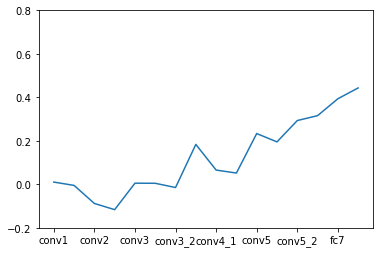

In [7]:
classes.correlate_integration_beauty(results_vgg16, places_images.beauty_ratings).plot(ylim=(-.2,.8))

test


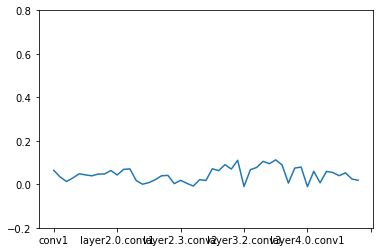

In [11]:
classes.correlate_integration_beauty(results_autoencoding, places_images.beauty_ratings).plot(ylim=(-.2,.8))

In [8]:
results_vgg16

,conv1,conv1_1,conv2,conv2_1,conv3,conv3_1,conv3_2,conv4,conv4_1,conv4_2,conv5,conv5_1,conv5_2,fc6,fc7,fc8a
0,-0.983123,-0.972471,-0.969690,-0.932361,-0.870340,-0.867848,-0.861324,-0.792860,-0.836010,-0.784744,-0.770835,-0.837915,-0.801580,-0.912642,-0.904536,-0.849672
1,-0.988474,-0.970777,-0.970677,-0.946647,-0.920898,-0.911696,-0.896856,-0.846613,-0.840459,-0.799933,-0.826476,-0.891256,-0.900086,-0.964162,-0.961519,-0.962565
2,-0.989495,-0.973141,-0.974408,-0.953882,-0.930552,-0.923199,-0.912643,-0.869097,-0.878391,-0.830931,-0.818602,-0.889172,-0.871852,-0.951417,-0.935921,-0.919300
3,-0.989586,-0.980083,-0.977478,-0.946990,-0.907716,-0.904630,-0.890270,-0.855537,-0.864602,-0.815427,-0.821811,-0.884210,-0.901800,-0.961100,-0.958398,-0.965751
4,-0.991258,-0.981188,-0.978538,-0.949577,-0.909039,-0.907792,-0.890851,-0.865774,-0.892154,-0.851080,-0.847102,-0.883068,-0.875207,-0.959389,-0.953732,-0.941918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-0.983311,-0.962983,-0.963242,-0.941431,-0.901636,-0.887660,-0.869910,-0.783837,-0.774626,-0.718336,-0.725431,-0.791481,-0.790926,-0.913020,-0.891236,-0.835036
246,-0.986610,-0.972127,-0.971881,-0.945548,-0.913277,-0.908537,-0.895740,-0.879633,-0.882571,-0.847796,-0.875402,-0.908133,-0.921162,-0.973889,-0.973316,-0.976925
247,-0.989653,-0.983949,-0.977510,-0.941544,-0.882314,-0.889077,-0.883545,-0.843965,-0.871419,-0.835822,-0.812478,-0.860232,-0.848119,-0.924650,-0.888101,-0.843361
248,-0.990375,-0.972764,-0.980901,-0.960154,-0.939933,-0.937857,-0.932748,-0.895055,-0.914636,-0.876649,-0.894824,-0.943529,-0.931882,-0.975520,-0.972920,-0.968108


In [12]:
places_images.beauty_ratings

0      86.00
1      70.76
2      33.68
3      35.84
4      40.72
       ...  
245    60.76
246    38.52
247    65.24
248    56.44
249    62.48
Length: 250, dtype: float64

# Inspect models

## Retrieve model weights

In [4]:
state = dict(vgg16_places.state_dict())

In [79]:
state.keys()

dict_keys(['conv1_1.weight', 'conv1_1.bias', 'conv1_2.weight', 'conv1_2.bias', 'conv2_1.weight', 'conv2_1.bias', 'conv2_2.weight', 'conv2_2.bias', 'conv3_1.weight', 'conv3_1.bias', 'conv3_2.weight', 'conv3_2.bias', 'conv3_3.weight', 'conv3_3.bias', 'conv4_1.weight', 'conv4_1.bias', 'conv4_2.weight', 'conv4_2.bias', 'conv4_3.weight', 'conv4_3.bias', 'conv5_1.weight', 'conv5_1.bias', 'conv5_2.weight', 'conv5_2.bias', 'conv5_3.weight', 'conv5_3.bias', 'fc6.weight', 'fc6.bias', 'fc7.weight', 'fc7.bias', 'fc8a.weight', 'fc8a.bias'])

In [18]:
# cant export variable names with . in them
savemat('../previous study/pynet_parameters.mat', {k.replace('.','_'):v.squeeze().detach().numpy() for k,v in state.items()})

## Prepare image 1153

In [133]:
im = torchvision.io.read_image('./data/stimuli_places1/Places365_val_00001153.jpg')
im.shape

torch.Size([3, 683, 512])

In [145]:
im = torchvision.transforms.Resize(size=(224,224))(im)
im.shape

torch.Size([3, 224, 224])

In [32]:
im = im.unsqueeze(0)
im.shape

torch.Size([1, 3, 224, 224])

### Import from matlab

#### Import resized image

In [96]:
from scipy.io import loadmat

In [156]:
matim = torch.tensor(loadmat('1153_resized.mat')['im'])
matim.shape

torch.Size([224, 224, 3])

In [142]:
matimv1= matim.permute((2, 0, 1))
matimv2= matim.permute((2, 1, 0))

In [144]:
matimv1.shape

torch.Size([3, 224, 224])

In [148]:
torch.sum(torch.abs(matimv1 - im), None)

tensor(278175.)

In [157]:
matim

tensor([[[ 24.,  23.,  12.],
         [ 28.,  28.,  11.],
         [ 47.,  46.,  20.],
         ...,
         [154., 113.,  74.],
         [114.,  74.,  49.],
         [128.,  97.,  79.]],

        [[ 58.,  61.,  38.],
         [ 54.,  57.,  31.],
         [ 53.,  55.,  26.],
         ...,
         [120.,  86.,  59.],
         [ 59.,  29.,  15.],
         [ 42.,  23.,  15.]],

        [[ 37.,  45.,  12.],
         [ 41.,  49.,  16.],
         [ 40.,  47.,  15.],
         ...,
         [150., 127., 114.],
         [ 44.,  27.,  24.],
         [  9.,   3.,   5.]],

        ...,

        [[  6.,  11.,   5.],
         [  5.,  10.,   4.],
         [  5.,  10.,   4.],
         ...,
         [ 24.,  61.,  49.],
         [ 25.,  61.,  49.],
         [ 22.,  58.,  46.]],

        [[  5.,  10.,   3.],
         [  6.,  11.,   5.],
         [  8.,  13.,   7.],
         ...,
         [ 23.,  59.,  47.],
         [ 21.,  57.,  45.],
         [ 20.,  56.,  44.]],

        [[  7.,  13.,   3.],
       

#### Import newly resized image

In [155]:
matim_newr = torch.tensor(loadmat('./stimuli_places1_resized/Places365_val_00001153.mat')['im'])
matim_newr

tensor([[[ 24.4403,  22.7511,  11.8139],
         [ 28.5003,  27.7502,  10.5162],
         [ 46.8996,  46.3545,  20.0937],
         ...,
         [153.5130, 112.6674,  73.4532],
         [114.1780,  74.9785,  48.7969],
         [128.2486,  97.4646,  79.0343]],

        [[ 58.0566,  61.1884,  38.2769],
         [ 54.2784,  57.5728,  31.4510],
         [ 52.6564,  55.1153,  25.7206],
         ...,
         [120.2437,  86.1312,  58.9014],
         [ 59.3425,  29.8225,  15.9405],
         [ 42.1073,  22.4860,  14.6503]],

        [[ 36.6029,  44.8355,  11.9996],
         [ 41.5014,  49.6405,  15.9324],
         [ 40.3692,  46.6992,  15.0638],
         ...,
         [149.5059, 125.8857, 112.6819],
         [ 44.9145,  27.8696,  25.1245],
         [  7.9466,   2.7646,   4.4362]],

        ...,

        [[  5.5892,  10.6544,   4.7645],
         [  5.1871,  10.2419,   4.3631],
         [  4.9662,  10.0252,   4.1319],
         ...,
         [ 24.3000,  60.3625,  48.4469],
         [ 24.2940,  6

#### Import original image

In [135]:
matim_o = loadmat('1153.mat')['im']
matim_o.shape

(683, 512, 3)

In [136]:
im = torchvision.io.read_image('./data/stimuli_places1/Places365_val_00001153.jpg')
im.shape

torch.Size([3, 683, 512])

In [137]:
matim_o = torch.tensor(matim_o).permute((2, 0, 1))


In [138]:
matim_o

tensor([[[  7,  16,  17,  ..., 155, 189, 167],
         [ 17,  17,  11,  ..., 120, 141, 109],
         [ 48,  38,  26,  ...,  84,  95,  65],
         ...,
         [  8,   7,   7,  ...,  21,  20,  19],
         [  8,   7,   7,  ...,  21,  20,  19],
         [  8,   7,   7,  ...,  21,  20,  19]],

        [[  4,  14,  15,  ..., 117, 157, 136],
         [ 15,  15,   9,  ...,  84, 108,  80],
         [ 49,  39,  27,  ...,  52,  66,  37],
         ...,
         [ 14,  13,  13,  ...,  57,  56,  55],
         [ 14,  13,  13,  ...,  57,  56,  55],
         [ 14,  13,  13,  ...,  57,  56,  55]],

        [[  0,   2,   2,  ...,  94, 136, 116],
         [  3,   3,   0,  ...,  62,  89,  62],
         [ 35,  23,   9,  ...,  31,  50,  23],
         ...,
         [  4,   3,   3,  ...,  45,  44,  43],
         [  4,   3,   3,  ...,  45,  44,  43],
         [  4,   3,   3,  ...,  45,  44,  43]]], dtype=torch.uint8)

In [139]:
im

tensor([[[  7,  16,  17,  ..., 155, 189, 167],
         [ 17,  17,  11,  ..., 120, 141, 109],
         [ 48,  38,  26,  ...,  84,  95,  65],
         ...,
         [  8,   7,   7,  ...,  21,  20,  19],
         [  8,   7,   7,  ...,  21,  20,  19],
         [  8,   7,   7,  ...,  21,  20,  19]],

        [[  4,  14,  15,  ..., 117, 157, 136],
         [ 15,  15,   9,  ...,  84, 108,  80],
         [ 49,  39,  27,  ...,  52,  66,  37],
         ...,
         [ 14,  13,  13,  ...,  57,  56,  55],
         [ 14,  13,  13,  ...,  57,  56,  55],
         [ 14,  13,  13,  ...,  57,  56,  55]],

        [[  0,   2,   2,  ...,  94, 136, 116],
         [  3,   3,   0,  ...,  62,  89,  62],
         [ 35,  23,   9,  ...,  31,  50,  23],
         ...,
         [  4,   3,   3,  ...,  45,  44,  43],
         [  4,   3,   3,  ...,  45,  44,  43],
         [  4,   3,   3,  ...,  45,  44,  43]]], dtype=torch.uint8)

In [140]:
torch.sum(torch.abs(matim_o - im),None)

tensor(0)

## Predictions for single image (without feature extractor)

In [37]:
output = vgg16_places(im.float())
output.shape

torch.Size([1, 365])

In [38]:
sorted, indices = torch.sort(output, descending=True)
torch.round(sorted, decimals=3)

tensor([[0.4230, 0.1970, 0.0920, 0.0390, 0.0330, 0.0220, 0.0190, 0.0130, 0.0100,
         0.0100, 0.0090, 0.0090, 0.0080, 0.0080, 0.0070, 0.0070, 0.0060, 0.0060,
         0.0060, 0.0040, 0.0040, 0.0040, 0.0040, 0.0030, 0.0030, 0.0030, 0.0030,
         0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
         0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

## Layer wise activation for tensor of ones

In [41]:
im.shape

torch.Size([1, 3, 224, 224])

In [36]:
one = 100*torch.ones(1, 3, 224, 224).float()

In [26]:
one_response = vgg16_places_fe(one)

In [27]:
one_response = {key:value.squeeze().detach().numpy() for key,value in one_response.items()}
one_response

{'conv1': array([[[-250.01726  , -208.89288  , -208.89288  , ..., -208.89288  ,
          -208.89288  ,  -14.344568 ],
         [-141.64545  ,    6.8668056,    6.8668056, ...,    6.8668056,
             6.8668056,  208.80591  ],
         [-141.64545  ,    6.8668056,    6.8668056, ...,    6.8668056,
             6.8668056,  208.80591  ],
         ...,
         [-141.64545  ,    6.8668056,    6.8668056, ...,    6.8668056,
             6.8668056,  208.80591  ],
         [-141.64545  ,    6.8668056,    6.8668056, ...,    6.8668056,
             6.8668056,  208.80591  ],
         [  53.162815 ,  232.3758   ,  232.3758   , ...,  232.3758   ,
           232.3758   ,  323.0214   ]],
 
        [[  21.037287 ,   23.117334 ,   23.117334 , ...,   23.117334 ,
            23.117334 ,   14.46842  ],
         [  24.374834 ,   23.9335   ,   23.9335   , ...,   23.9335   ,
            23.9335   ,   14.352503 ],
         [  24.374834 ,   23.9335   ,   23.9335   , ...,   23.9335   ,
            23.9335   ,

In [71]:
one_response['conv1'].dtype

dtype('float32')

In [28]:
## Export to matlab
savemat('../previous study/activations_hundredtensor.mat', one_response)

## Layers wise activations for image 1153

In [ ]:
"""
Check if activation (matlab) and feature extraction (pytorch) return the same values
Can check also only correlations, which would include checking the image transformations. 

"""

In [9]:
def checkerboard(scale, output_size=224):
    board = np.indices((scale,scale)).sum(axis=0) % 2
    board = board.repeat(output_size/scale,axis=0).repeat(output_size/scale, axis=1)
    board = board[np.newaxis,:,:].repeat(3,axis=0)
    return board.astype(dtype = np.bool_)

In [115]:
img = torchvision.io.read_image('./data/stimuli_places1/Places365_val_00001153.jpg')
img_resizer = torchvision.transforms.Resize((224,224))
img = img_resizer(img)

pattern = checkerboard(2, output_size=224)
img2 = img.clone()
img1 = img.clone()
img1[~pattern] = 127
img2[pattern] = 127

img, img1, img2 = img.unsqueeze(0), img1.unsqueeze(0), img2.unsqueeze(0) 
img = img.float()

In [116]:
img_act = vgg16_places_fe(img)

In [121]:
savemat('../previous study/activations1153.mat', {key:value.squeeze().detach().numpy() for key,value in img_act.items()})